# Usage dynamics of the Bike-Sharing System of San Francisco Bay Area
## by Affonso Ciekalski

## Investigation Overview


>  This investigation aimed at undertanding how the usage of the bike-sharing system varies along the week. The main focus will be on the variance between weekdays and weekends, and includes the usage dynamics along the day, as well as the duration of trips and the gender distribution.


## Dataset Overview

>  This dataset presents just over 180k trips registered with 15 features that include information on the trips and on the users.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# center the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# load in the dataset into a pandas dataframe
bike_share = pd.read_csv('201902-fordgobike-tripdata.csv')

In [4]:
# convert duration from seconds to minutes
bike_share['duration_min'] = bike_share['duration_sec'] // 60

# drop the column with duration in seconds
bike_share.drop(columns='duration_sec', inplace = True)

In [5]:
# convert start_time and end_time to Datatime DataType
bike_share.start_time = pd.to_datetime(bike_share.start_time)
bike_share.end_time = pd.to_datetime(bike_share.end_time)

# create a column for the day of the week when the trip started
bike_share['day_of_week'] = bike_share.start_time.dt.day_name()

# create a column for the time of the day when the trip started
bike_share['time_of_day'] = bike_share.start_time.dt.hour

# create an age attribute by subtracting 2019 (year of the data) and member_birth_year column
bike_share['member_age'] = 2019 - bike_share['member_birth_year']

In [6]:
geo_cols = ['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'] 

# drop geolocalization data
bike_share.drop(columns = geo_cols, inplace = True)

In [7]:
# convert 'day_of_week' into ordered categorical type
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
ordered_week = pd.api.types.CategoricalDtype(ordered = True, categories = weekdays)
bike_share['day_of_week'] = bike_share['day_of_week'].astype(ordered_week)

## Gender Distribution Among Users

Trips made by people identifying themselves as Male comprise around 75% of the total as shown in the pie chart. This gender gap will be the object of further visualizations.

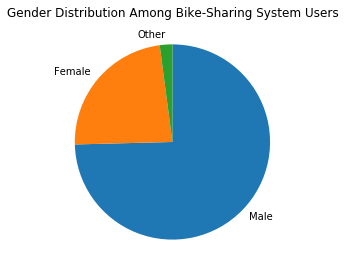

In [8]:
# plot relative frequency of each gender 
gender_freq = bike_share.member_gender.value_counts()

plt.pie(gender_freq, labels = gender_freq.index, startangle = 90, counterclock = False)
plt.title('Gender Distribution Among Bike-Sharing System Users', y = 1.05)
plt.axis('square')
plt.show();

In [9]:
# select outliers using 90 as age limit for this analysis
over_90_years = bike_share[['user_type','member_birth_year','member_age', 'duration_min', 
                            'day_of_week', 'time_of_day']].loc[bike_share['member_age'] > 90]
# dropping rows with member over 90 years old following the exploratory process
bike_share = bike_share.drop(over_90_years.index)

In [10]:
# instantiate the trip duration
trip_duration = bike_share['duration_min']

# select outliers with duration over 50 minutes
over_50_min = bike_share[['duration_min', 'time_of_day']].loc[trip_duration > 50]

# drop trips with duration over 50 minutes following the exploratory process
bike_share = bike_share.drop(over_50_min.index)

## Distribution of the Duration of the Trips

> When plotting on a log-scale, the duration distribution looks unimodal with the peak at 10 minutes. Most of the trips last from 4 to 20 minutes.

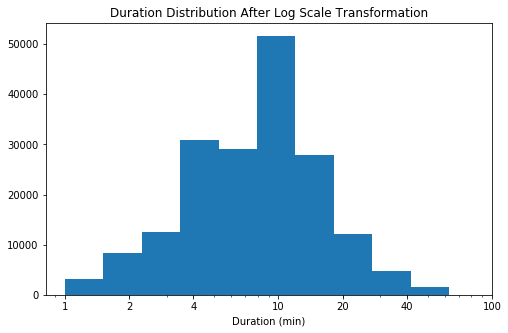

In [11]:
# log transformation of the duration distribution
# setting figure size
plt.figure(figsize = (8, 5))

# setting bin size
bins = 10 ** np.arange(0, 1.8+0.1, 0.18)

# Generate the x-ticks
ticks = [1, 2, 4, 10, 20, 40, 100]
# Convert ticks into string values, to be displayed along the x-axis
labels = ['{}'.format(v) for v in ticks]

# plot log-scaled duration distribution 
plt.hist(trip_duration.dropna(), bins = bins)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.title('Duration Distribution After Log Scale Transformation')
plt.xlabel('Duration (min)')
plt.show();

## Hourly Number of Trips vs. Days of the Week

On weekdays, the usage presents two peaks related to the time people go to work and the time they go back home. They happen at around 8 (a.m.) and around 17 (5 p.m.).

Looking at the red line representing the weekends mean, it is possible to notice that the bike-sharing dynamic is different on weekends. The peak happens at 13/14 (1/2 p.m.) with high levels of people using the system from 10 (a.m.) to 18 (6 p.m.).

In [12]:
# group trips per hour per day of the week
trips_day_week = bike_share.time_of_day.groupby(bike_share.day_of_week).value_counts()

# instantiate the trips for each day of the week
monday_trips = trips_day_week.loc['Monday'].sort_index()
tuesday_trips = trips_day_week.loc['Tuesday'].sort_index()
wednesday_trips = trips_day_week.loc['Wednesday'].sort_index()
thursday_trips = trips_day_week.loc['Thursday'].sort_index()
friday_trips = trips_day_week.loc['Friday'].sort_index()
saturday_trips = trips_day_week.loc['Saturday'].sort_index()
sunday_trips = trips_day_week.loc['Sunday'].sort_index()

# calculate the mean of trips per hour for weekdays and for weekend
mean_weekdays_trips = (monday_trips + tuesday_trips + wednesday_trips + thursday_trips + friday_trips)//5
mean_weekend_trips = (saturday_trips + sunday_trips)//2

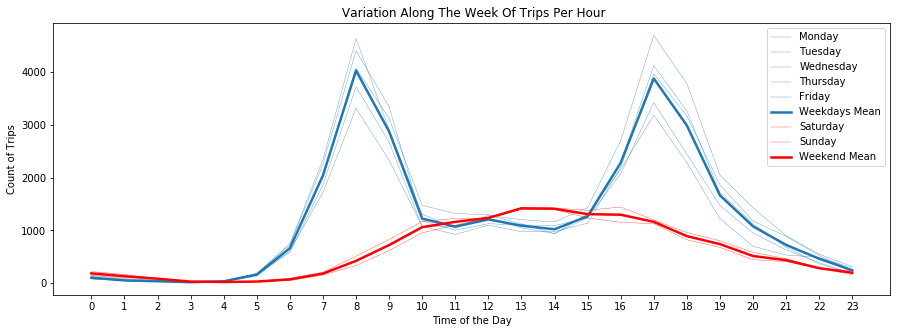

In [13]:
# set color for weekdays and the plot size
color_weekdays = sb.color_palette()[0]
plt.figure(figsize = [15, 5])

# plot weekdays
plt.plot(monday_trips, color = color_weekdays, lw = 0.3)
plt.plot(tuesday_trips, color = color_weekdays, lw = 0.3)
plt.plot(wednesday_trips, color = color_weekdays, lw = 0.3)
plt.plot(thursday_trips, color = color_weekdays, lw = 0.3)
plt.plot(friday_trips, color = color_weekdays, lw = 0.3)
plt.plot(mean_weekdays_trips, color = color_weekdays, lw = 2.5)

# plot weekend
plt.plot(saturday_trips, color = 'r', lw = 0.3)
plt.plot(sunday_trips, color = 'r', lw = 0.3)
plt.plot(mean_weekend_trips, color = 'r', lw = 2.5)

# use monday_trips indices as ticks in x-axis and set legend
plt.xticks(monday_trips.index)
plt.legend(labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Weekdays Mean',
                     'Saturday', 'Sunday', 'Weekend Mean'])
plt.title(' Variation Along The Week Of Trips Per Hour')
plt.xlabel('Time of the Day')
plt.ylabel('Count of Trips')
plt.show();

## Duration of the Trips Along the Week for Each Gender 

The point plot clearly shows that trips tend to be longer on weekends. Furthermore, trips made by Male individuals are shorter than those made by the other genders in all days of the week. One possible explanation for this difference might be the feeling of insecurity on the streets that make women less prone to cycle, in other words, women might be more careful to ride a bike than men, resulting in longer trips.

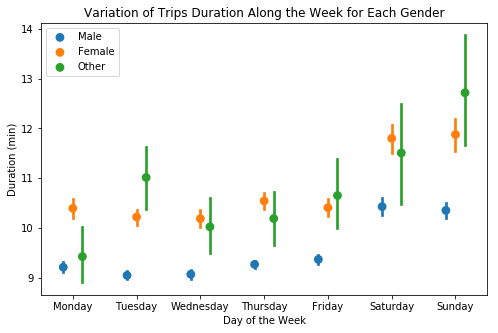

In [14]:
# point plot of the trips duration for each gender in each day of the week
plt.figure(figsize = [8, 5])
ax = sb.pointplot(data = bike_share, x = 'day_of_week', y = 'duration_min', hue = 'member_gender',
                  dodge = 0.3, linestyles = "")
ax.legend(loc = 2)
plt.title('Variation of Trips Duration Along the Week for Each Gender')
plt.xlabel('Day of the Week')
plt.ylabel('Duration (min)')
plt.show();

## Duration of the Trips Along the Day for Each Gender

The scarcity of data points from 23 (11 p.m.) to 5 (a.m.) makes it difficult to visualize patterns in this period. 

On the other hand, there is a clear pattern in the period starting at 6 (a.m.) till 22 (10 p.m.). Here we notice, one more time, that trips made by Male individuals are shorter than those made by the other genders. In addition, for all genders, trips seem to be shorter in the morning (from 6 to 9 a.m.) and at night and longer around noon.

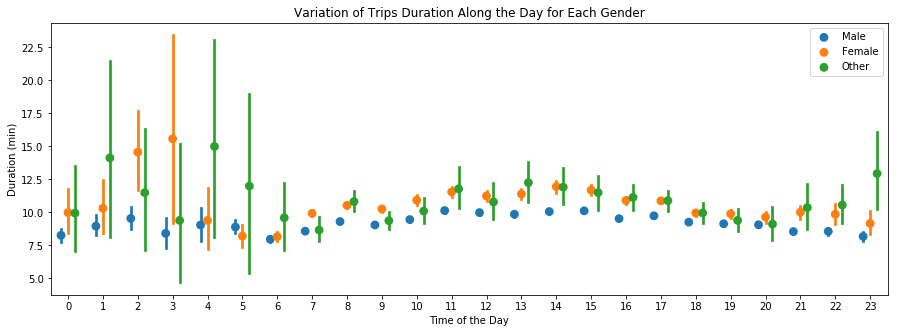

In [15]:
# point plot of the duration of the trips for each gender in hour of the day
plt.figure(figsize = [15, 5])
ax = sb.pointplot(data = bike_share, x = 'time_of_day', y = 'duration_min', hue = 'member_gender',
                  dodge = 0.4, linestyles = "")
ax.legend(loc = 1)
plt.title('Variation of Trips Duration Along the Day for Each Gender')
plt.xlabel('Time of the Day')
plt.ylabel('Duration (min)')
plt.show();

## Gender Distribution on Thursdays and on Saturdays Along the Day 

I decided to use trips made on Thursdays to represent weekdays as this is the busiest day of the week, and those made on Saturdays to represent weekends.

It seems that the gender distribution is quite constant on weekdays following the pattern of two peaks representing the home-work-home routine. The same does not hold true for weekends, when the bike-sharing system is busier in the late morning and in the afternoon.

In [16]:
thursday_trips = bike_share.query('day_of_week == "Thursday"')
saturday_trips = bike_share.query('day_of_week == "Saturday"')

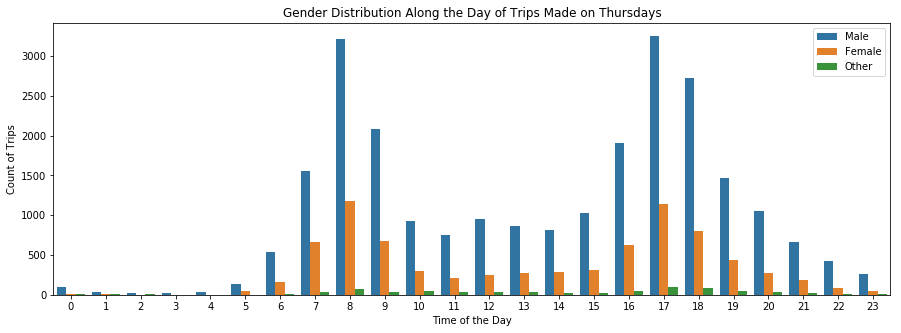

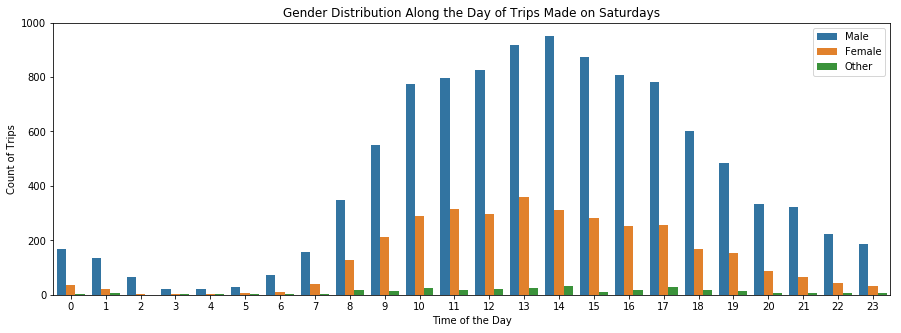

In [17]:
# plot the number of trips made on Thursdays in each time of the day for each gender 
plt.figure(figsize = [15, 5])
ax = sb.countplot(data = thursday_trips, x = 'time_of_day', hue = 'member_gender')
ax.legend(loc = 1)
plt.title('Gender Distribution Along the Day of Trips Made on Thursdays')
plt.xlabel('Time of the Day')
plt.ylabel('Count of Trips');

# plot the number of trips made on Saturdays in each time of the day for each gender 
plt.figure(figsize = [15, 5])
ax = sb.countplot(data = saturday_trips, x = 'time_of_day', hue = 'member_gender')
ax.legend(loc = 1)
plt.title('Gender Distribution Along the Day of Trips Made on Saturdays')
plt.xlabel('Time of the Day')
plt.ylabel('Count of Trips')
plt.show();

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Project_Bike_Share_Part_II.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Project_Bike_Share_Part_II.ipynb to slides
[NbConvertApp] Writing 500375 bytes to Project_Bike_Share_Part_II.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Project_Bike_Share_Part_II.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg